<a href="https://colab.research.google.com/github/Ayllinice/Filin_AI_Labs/blob/main/LAB3AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа №3
Филин Илья Александрович

БИВТ-22-СП-4

## 1. Загрузка данных

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
data = pd.read_csv("/content/drive/MyDrive/Sleep_health_and_lifestyle_dataset.csv")

## 2. Определение типа задачи

**Целевое событие** – это предсказание наличия расстройства сна у человека, основываясь на других параметрах.
Событие **дискретно**. У целевой переменной Sleep Disorder 3 уникальных значения -Nan (отсутствие нарушения), Sleep Apnea (приостановка дыхания во сне) и Insomnia (бессоница).

**Тип задачи** - задача многоклассовой классификации, т.к. необходимо определить не только наличие или отсутствие расстройства сна, но и его тип.

## 3. Предобработка данных

### 3.1. Разбиение на выборки

Разобьем данные на выборки для тренировки (train_data) и тестирования (test_data) в соотношении 70%-30% от всех данных.

In [ ]:
# индекс для разбиения
split_i= int(0.7 * len(data))

# перемешиваем данные
data_shuffled = data.sample(frac=1, random_state=13).reset_index(drop=True) #12, чтобы при запуске всех клеток не было изменений

# разделяем данные
train_data = data_shuffled[:split_i]
test_data = data_shuffled[split_i:]

# Вывод размеров наборов данных
print(f"Кол-во записей train ({round(train_data.shape[0]*100/data.shape[0],2)}%):{train_data.shape[0]}")
print(f"Кол-во записей test ({round(test_data.shape[0]*100/data.shape[0],2)}%):{test_data.shape[0]}")

Кол-во записей train (69.79%):261
Кол-во записей test (30.21%):113


### 3.2. Пропуски в данных

Проверим пропуски в train данных и заполним их

In [ ]:
train_data.isnull().sum()

Person ID                    0
Gender                       0
Age                          0
Occupation                   0
Sleep Duration               0
Quality of Sleep             0
Physical Activity Level      0
Stress Level                 0
BMI Category                 0
Blood Pressure               0
Heart Rate                   0
Daily Steps                  0
Sleep Disorder             157
dtype: int64

Пропуск присутствует только в целевой переменной. Он означает отсутствие расстройства сна, что можно заменить на категорию "None".

In [ ]:
# записи с пропусками
nan_rows_data = train_data[train_data["Sleep Disorder"].isna()]
nan_rows_data = test_data[test_data["Sleep Disorder"].isna()]

# выводим пример записи с NaN
print("До заполнения NaN:")
print(nan_rows_data[["Person ID","Sleep Disorder"]].iloc[0:1])
person_id = nan_rows_data.iloc[0]["Person ID"]  # запоминает person ID для повторного вывода

# заполняем NaN на "None" во всех записях
train_data.loc[:, "Sleep Disorder"] = train_data["Sleep Disorder"].fillna("None") # : - все строки
test_data.loc[:, "Sleep Disorder"] = test_data["Sleep Disorder"].fillna("None") # : - все строки

# проверяем ту же запись после исправления
nan_rows_test_after = train_data[train_data["Person ID"] == person_id]
print("\nПосле заполнения None:")
print(nan_rows_test_after[["Person ID", "Sleep Disorder"]])


До заполнения NaN:
     Person ID Sleep Disorder
261          9            NaN

После заполнения None:
Empty DataFrame
Columns: [Person ID, Sleep Disorder]
Index: []


#### 3.3. Нормирование численных переменных

К численным переменным в данном датасете относятся: Age, Sleep Duration, Quality of Sleep, Physical Activity Level, Stress Level, Heart Rate, Daily Steps.

Применим MinMaxScaler, когда данные имеют логические ограничения (шкалы):Quality of Sleep, Physical Activity Level, Stress Level

StandardScaler применим для остальных переменных: Age, Sleep Duration, Heart Rate, Daily Steps


In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import warnings
warnings.filterwarnings('ignore')

print('До нормирования train_data:')
print(train_data[['Quality of Sleep', 'Age']].head())

# признаки для MinMaxScaler и StandardScaler
min_max_columns = ['Quality of Sleep', 'Physical Activity Level', 'Stress Level']
standard_scaler_columns = ['Age', 'Sleep Duration', 'Heart Rate', 'Daily Steps']

# нормирование, используя train_data
min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

train_data[min_max_columns] = min_max_scaler.fit_transform(train_data[min_max_columns])
train_data[standard_scaler_columns] = standard_scaler.fit_transform(train_data[standard_scaler_columns])

print('После нормирования:')
print(train_data[['Quality of Sleep', 'Age']].head())


# нормирование test_data, используя train_data
test_data[min_max_columns] = min_max_scaler.transform(test_data[min_max_columns])
test_data[standard_scaler_columns] = standard_scaler.transform(test_data[standard_scaler_columns])

warnings.filterwarnings('default')


До нормирования train_data:
   Quality of Sleep  Age
0                 5   29
1                 8   41
2                 6   50
3                 7   30
4                 7   31
После нормирования:
   Quality of Sleep       Age
0               0.2 -1.503163
1               0.8 -0.118892
2               0.4  0.919312
3               0.6 -1.387807
4               0.6 -1.272451


### 3.4. Кодирование категориальных признаков

К категориальным признакам в данном датасете относятся: Gender, Occupation, BMI Category, Blood Pressure, Sleep Disorder

Применим Label Encoder, когда данные можно ограничить количество категорий: Gender, BMI Category, Sleep Disorder

One Hot Encoding применим для остальных переменных: Occupation, Blood Pressure

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoded_data = train_data.copy()
label_encoder = LabelEncoder()
encoded_data_test=test_data.copy()

# признаки для Label Encoding
label_columns = ['Gender', 'BMI Category', 'Sleep Disorder']

print('Кодирование:')
for column in label_columns:
    encoded_data[column] = label_encoder.fit_transform(train_data[column])
    encoded_data_test[column] = label_encoder.transform(test_data[column])

    # оригинальные и закодированные значения
    original_values = train_data[column].unique()
    encoded_values = encoded_data[column].unique()

    print(f"{column}:")
    for i, original in enumerate(original_values):
        print(f"{original} = {encoded_values[i]}")
    print()

# закодированные данные обратно в train_data
train_data.loc[:, label_columns] = encoded_data.loc[:, label_columns]
test_data.loc[:, label_columns] = encoded_data_test.loc[:, label_columns]


Кодирование:
Gender:
Female = 0
Male = 1

BMI Category:
Normal Weight = 1
Normal = 0
Overweight = 3
Obese = 2

Sleep Disorder:
Insomnia = 0
None = 1
Sleep Apnea = 2



One Hot Encoding применим для остальных переменных: Occupation, Blood Pressure

In [ ]:
# One-Hot Encoding и префиксы
train_data = pd.get_dummies(train_data, columns=['Occupation', 'Blood Pressure'], prefix=['Occupation', 'Blood Pressure'])
test_data = pd.get_dummies(test_data, columns=['Occupation', 'Blood Pressure'], prefix=['Occupation', 'Blood Pressure'])

# список столбцов с префиксами
train_columns = set(train_data.columns)
test_columns = set(test_data.columns)

# 1) если столбец есть в train_data, но нет в test_data, добавляем в test_data со значением False
for col in train_columns:
    if col.startswith('Occupation') or col.startswith('Blood Pressure'):
        if col not in test_columns:
            test_data[col] = False

# 2) если столбец есть в test_data, но нет в train_data, удаляем его из test_data
for col in test_columns:
    if col.startswith('Occupation') or col.startswith('Blood Pressure'):
        if col not in train_columns:
            test_data.drop(columns=[col], inplace=True)

# подсчет столбцов по префиксам
occupation_columns_train = [col for col in train_data.columns if col.startswith('Occupation')]
blood_pressure_columns_train = [col for col in train_data.columns if col.startswith('Blood Pressure')]

occupation_columns_test = [col for col in test_data.columns if col.startswith('Occupation')]
blood_pressure_columns_test = [col for col in test_data.columns if col.startswith('Blood Pressure')]

# количество столбцов для каждого префикса в обеих выборках
print("Occupation :", len(occupation_columns_train), len(occupation_columns_test))
print("Blood Pressure", len(blood_pressure_columns_train),len(blood_pressure_columns_test))

Occupation : 11 11
Blood Pressure 23 23


In [ ]:
# преобразование всех переменных в числовой формат для работы моделей
train_data = train_data.apply(pd.to_numeric, errors='coerce')
test_data = test_data.apply(pd.to_numeric, errors='coerce')

### 3.5. Преобразованные данные

In [ ]:
print("Train Data:")
display(train_data.head())
print()
print("Test Data:")
display(test_data.head())

Train Data:


,Person ID,Gender,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,...,Blood Pressure_130/85,Blood Pressure_130/86,Blood Pressure_131/86,Blood Pressure_132/87,Blood Pressure_135/88,Blood Pressure_135/90,Blood Pressure_139/91,Blood Pressure_140/90,Blood Pressure_140/95,Blood Pressure_142/92
0,19,0,-1.503163,-0.759921,0.2,0.166667,0.8,1,2.377519,-1.725277,...,False,False,False,True,False,False,False,False,False,False
1,173,1,-0.118892,0.743599,0.8,1.000000,0.4,0,-0.086867,0.751606,...,True,False,False,False,False,False,False,False,False,False
2,290,0,0.919312,-1.261094,0.4,1.000000,1.0,3,1.145326,1.990047,...,False,False,False,False,False,False,False,False,True,False
3,30,1,-1.387807,0.994185,0.6,0.750000,0.6,0,-0.086867,0.751606,...,False,False,False,False,False,False,False,False,False,False
4,38,1,-1.272451,0.618306,0.6,0.750000,0.6,0,-0.086867,0.751606,...,False,False,False,False,False,False,False,False,False,False



Test Data:


,Person ID,Gender,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,...,Blood Pressure_128/84,Blood Pressure_142/92,Occupation_Manager,Blood Pressure_135/88,Blood Pressure_126/83,Occupation_Software Engineer,Blood Pressure_128/85,Blood Pressure_118/75,Blood Pressure_119/77,Blood Pressure_118/76
261,9,1,-1.503163,0.868892,0.6,0.75,0.6,0,-0.086867,0.751606,...,False,False,False,False,False,False,False,False,False,False
262,50,1,-1.272451,0.743599,0.6,0.75,0.6,0,-0.086867,0.751606,...,False,False,False,False,False,False,False,False,False,False
263,95,0,-0.695671,0.117132,0.8,0.50,0.2,0,-0.579744,0.132385,...,False,False,False,False,False,False,False,False,False,False
264,123,0,-0.580315,0.117132,0.8,0.50,0.2,0,-0.579744,0.132385,...,False,False,False,False,False,False,False,False,False,False
265,370,0,1.957515,1.244772,1.0,0.75,0.0,3,-0.579744,0.132385,...,False,False,False,False,False,False,False,False,False,False


## 4. Обучение на train

Т.к. задача многоклассовой классификации, то используем модели LogisticRegression, DecisionTreeClassifier, KNeighborsClassifier, и RandomForestClassifier.

Подготовим данные.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# признаки для модели (исключаем целевую переменную)
X_train = train_data.drop(columns=['Sleep Disorder'])
y_train = train_data['Sleep Disorder']

X_test = test_data.drop(columns=['Sleep Disorder'])
y_test = test_data['Sleep Disorder']

# X_train и X_test к одинаковому порядку столбцов
X_train = X_train[sorted(X_train.columns)]
X_test = X_test[sorted(X_test.columns)]

### 4.1. LogisticRegression

In [ ]:
log_model = LogisticRegression(max_iter=1500)
log_model.fit(X_train, y_train)

y_pred_log = log_model.predict(X_test)
y_pred_log_train = log_model.predict(X_train)

### 4.2. DecisionTreeClassifier

In [ ]:
tree_model = DecisionTreeClassifier(max_depth=None, random_state=42) #изначально None/42 поставили, оптимальнее 6-7
tree_model.fit(X_train, y_train)

y_pred_tree = tree_model.predict(X_test)
y_pred_tree_train = tree_model.predict(X_train)


### 4.3. KNeighborsClassifier

In [ ]:
neigh_model = KNeighborsClassifier(n_neighbors=5)  #изначально 5, оптимальнее 2-3
neigh_model.fit(X_train, y_train)

y_pred_neigh = neigh_model.predict(X_test)
y_pred_neigh_train = neigh_model.predict(X_train)

### 4.4. RandomForestClassifier

In [ ]:
forest_model = RandomForestClassifier(n_estimators=100, random_state=42) #изначально 100/42, оптимальнее 10-16
forest_model.fit(X_train, y_train)

y_pred_forest = forest_model.predict(X_test)
y_pred_forest_train = forest_model.predict(X_train)


## 5. Подсчет метрик

Для задачи классификации -- Accuracy, ROC-AUC (график + значение), PR-кривую (график), F1-score

### 5.1. Тестовые данные

#### 5.1.1 Accuracy

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_log = accuracy_score(y_test, y_pred_log)
accuracy_tree = accuracy_score(y_test, y_pred_tree)
accuracy_neigh = accuracy_score(y_test, y_pred_neigh)
accuracy_forest = accuracy_score(y_test, y_pred_forest)

print("Accuracy")
print(f'  Для логистической регрессии: {accuracy_log:.4f}')
print(f'  Для дерева решений: {accuracy_tree:.4f}')
print(f'  Для KNN: {accuracy_neigh:.4f}')
print(f'  Для случайного леса: {accuracy_forest:.4f}')


Accuracy
  Для логистической регрессии: 0.8850
  Для дерева решений: 0.8761
  Для KNN: 0.8319
  Для случайного леса: 0.8938


Наибольшее значение по метрике "Точность" у модели Random Forest.

#### 5.1.2. ROC_AUC

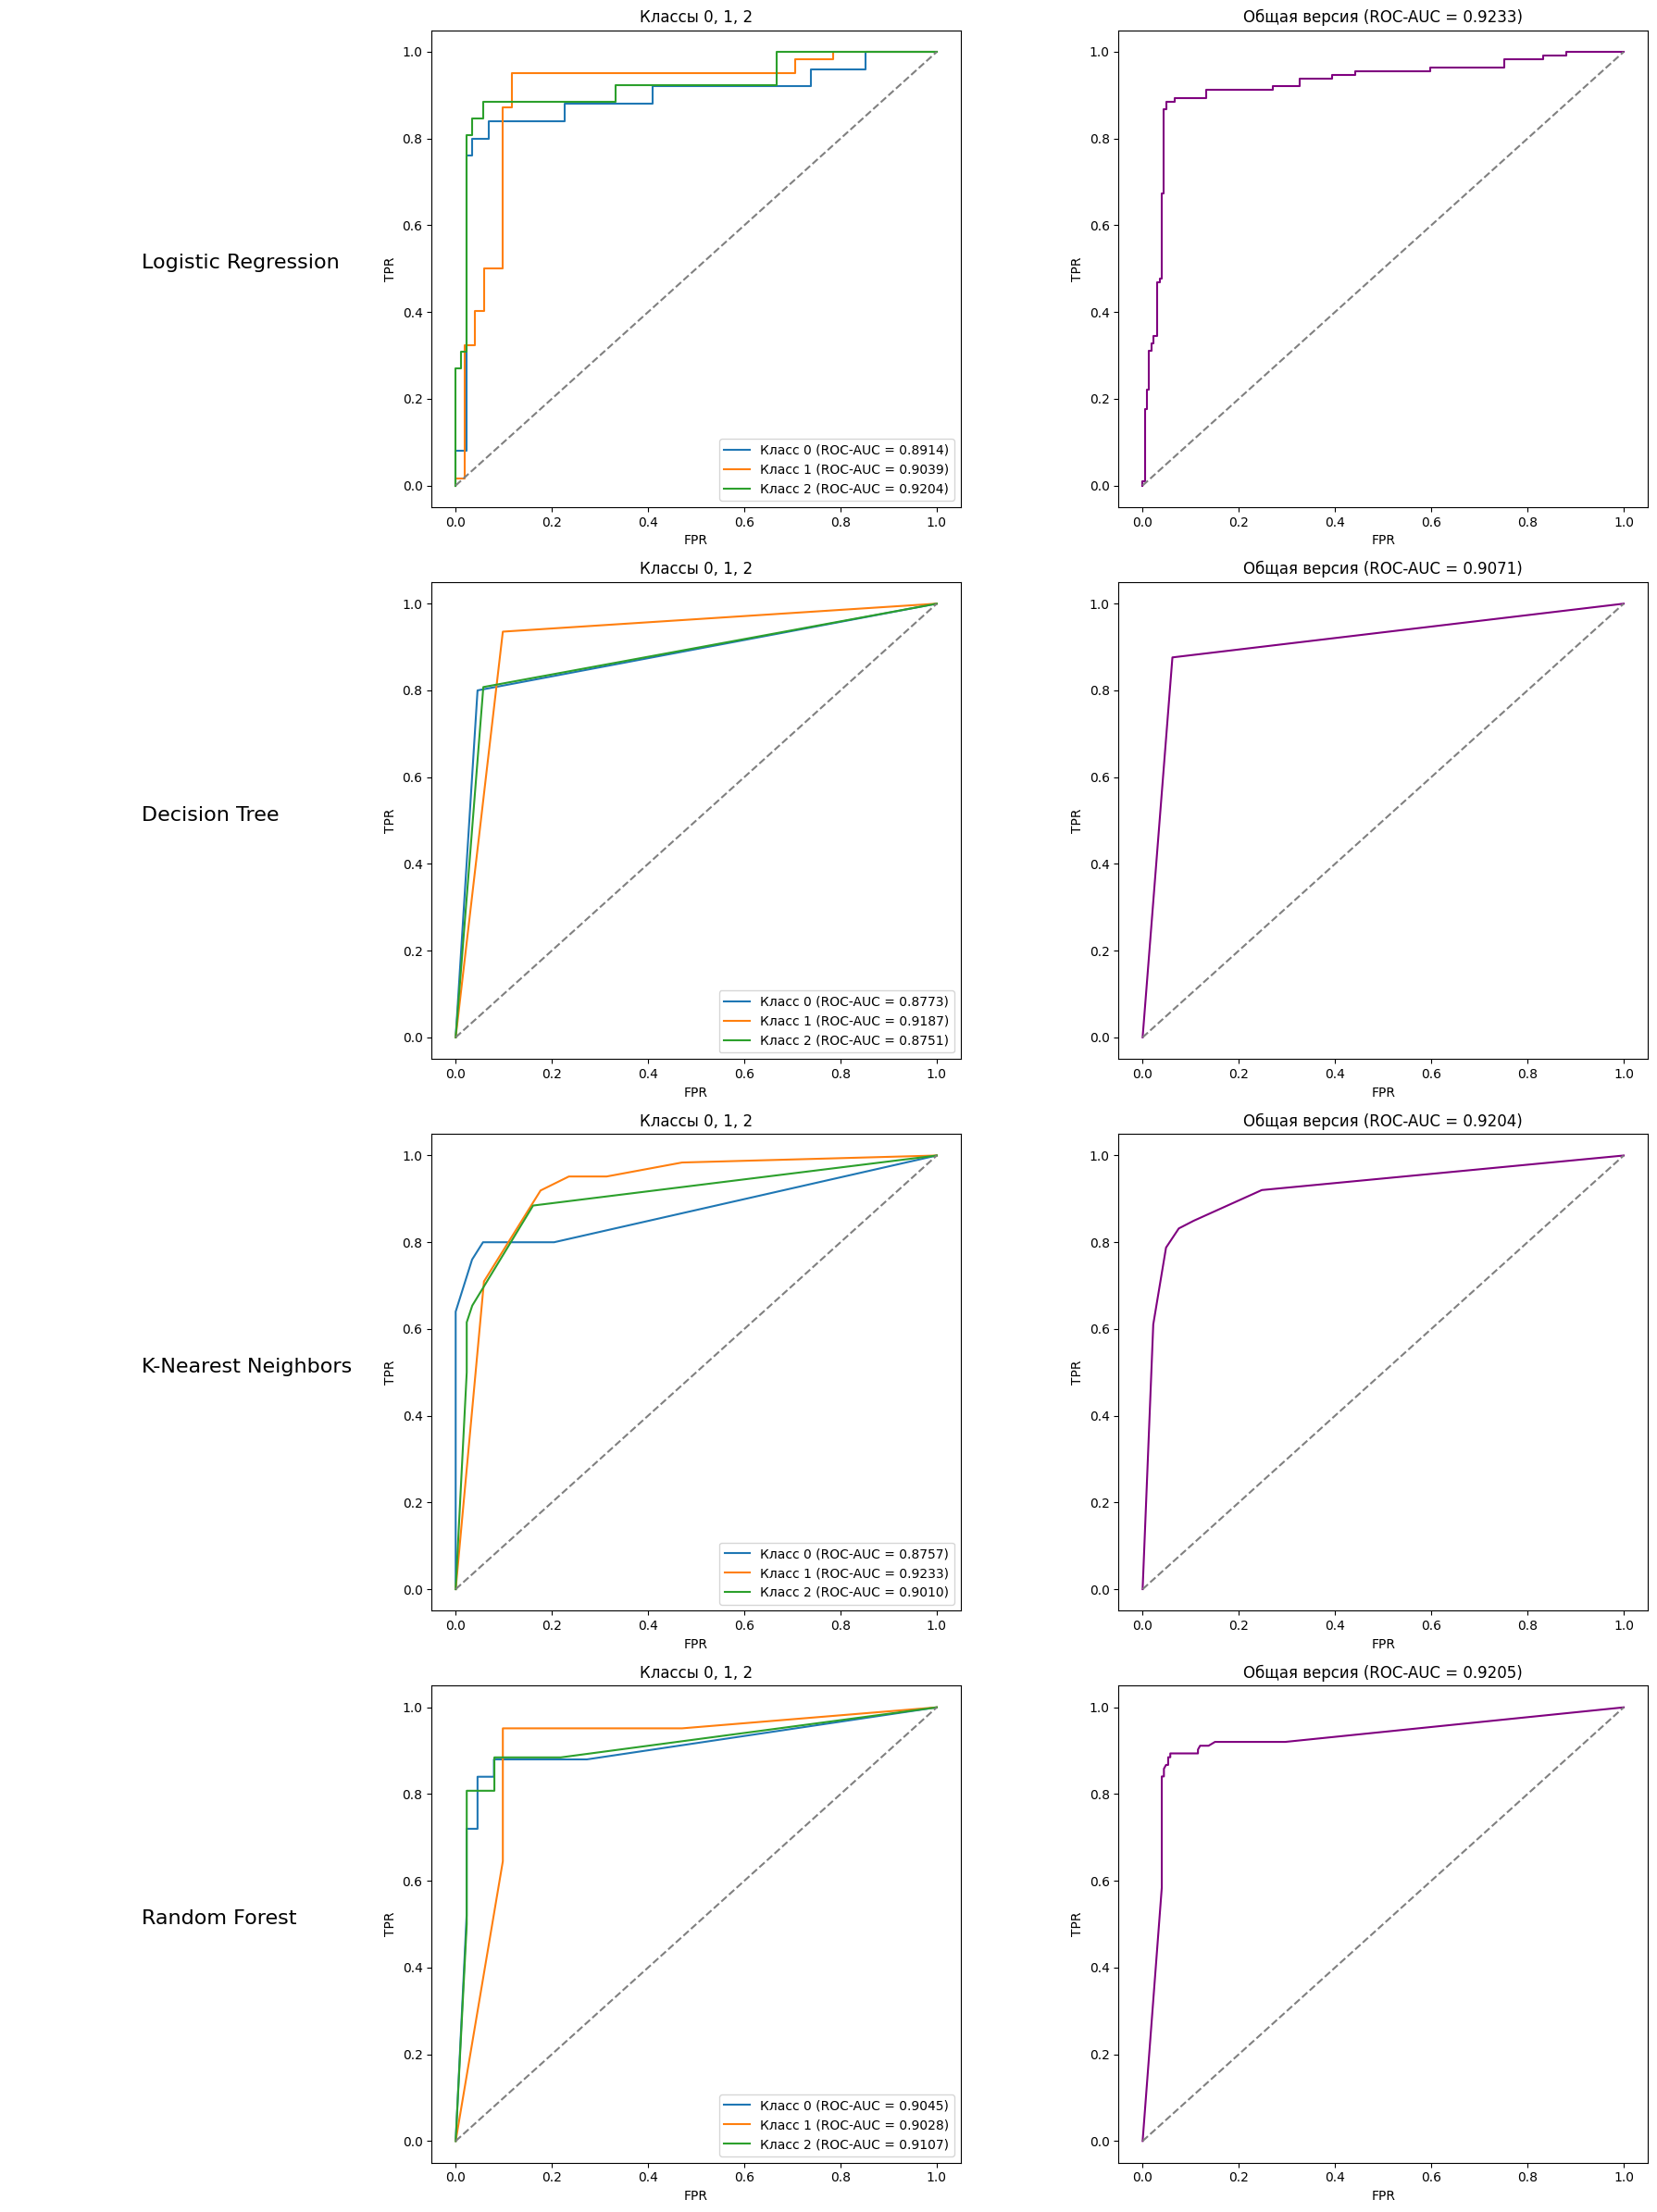

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# бинаризация целевой переменной (т.к. не 2, а 3 класса)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

# вероятности для всех моделей
model_names = ["Logistic Regression", "Decision Tree", "K-Nearest Neighbors", "Random Forest"]
predictions = [
    log_model.predict_proba(X_test),
    tree_model.predict_proba(X_test),
    neigh_model.predict_proba(X_test),
    forest_model.predict_proba(X_test)
]

fig, axs = plt.subplots(4, 3, figsize=(18, 6 * len(model_names)),gridspec_kw={'width_ratios': [1, 2, 2]})

for row in range(len(model_names)):
    model_name = model_names[row]
    y_pred_proba = predictions[row]

    # название модели
    axs[row, 0].text(0.5, 0.5, model_name, fontsize=16)
    axs[row, 0].axis('off')

    # ROC для классов 0, 1, 2
    for i in range(3):
        fpr, tpr, thresholds = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        axs[row, 1].plot(fpr, tpr, label=f'Класс {i} (ROC-AUC = {roc_auc:.4f})')
    axs[row, 1].plot([0, 1], [0, 1], color='grey', linestyle='--') # диагональ
    axs[row, 1].set_title("Классы 0, 1, 2")
    axs[row, 1].set_xlabel('FPR')
    axs[row, 1].set_ylabel('TPR')
    axs[row, 1].legend()

    # общий для всех классов
    fpr_all, tpr_all, thresholds_all = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
    roc_auc_all = auc(fpr_all, tpr_all)
    axs[row, 2].plot(fpr_all, tpr_all, color='purple')
    axs[row, 2].plot([0, 1], [0, 1], color='grey', linestyle='--') # диагональ
    axs[row, 2].set_title(f"Общая версия (ROC-AUC = {roc_auc_all:.4f})")
    axs[row, 2].set_xlabel('FPR')
    axs[row, 2].set_ylabel('TPR')


plt.tight_layout()
plt.show()


Лучшая общая оценка ROC-AUC: Logistic Regression

#### 5.1.3. PR-кривая

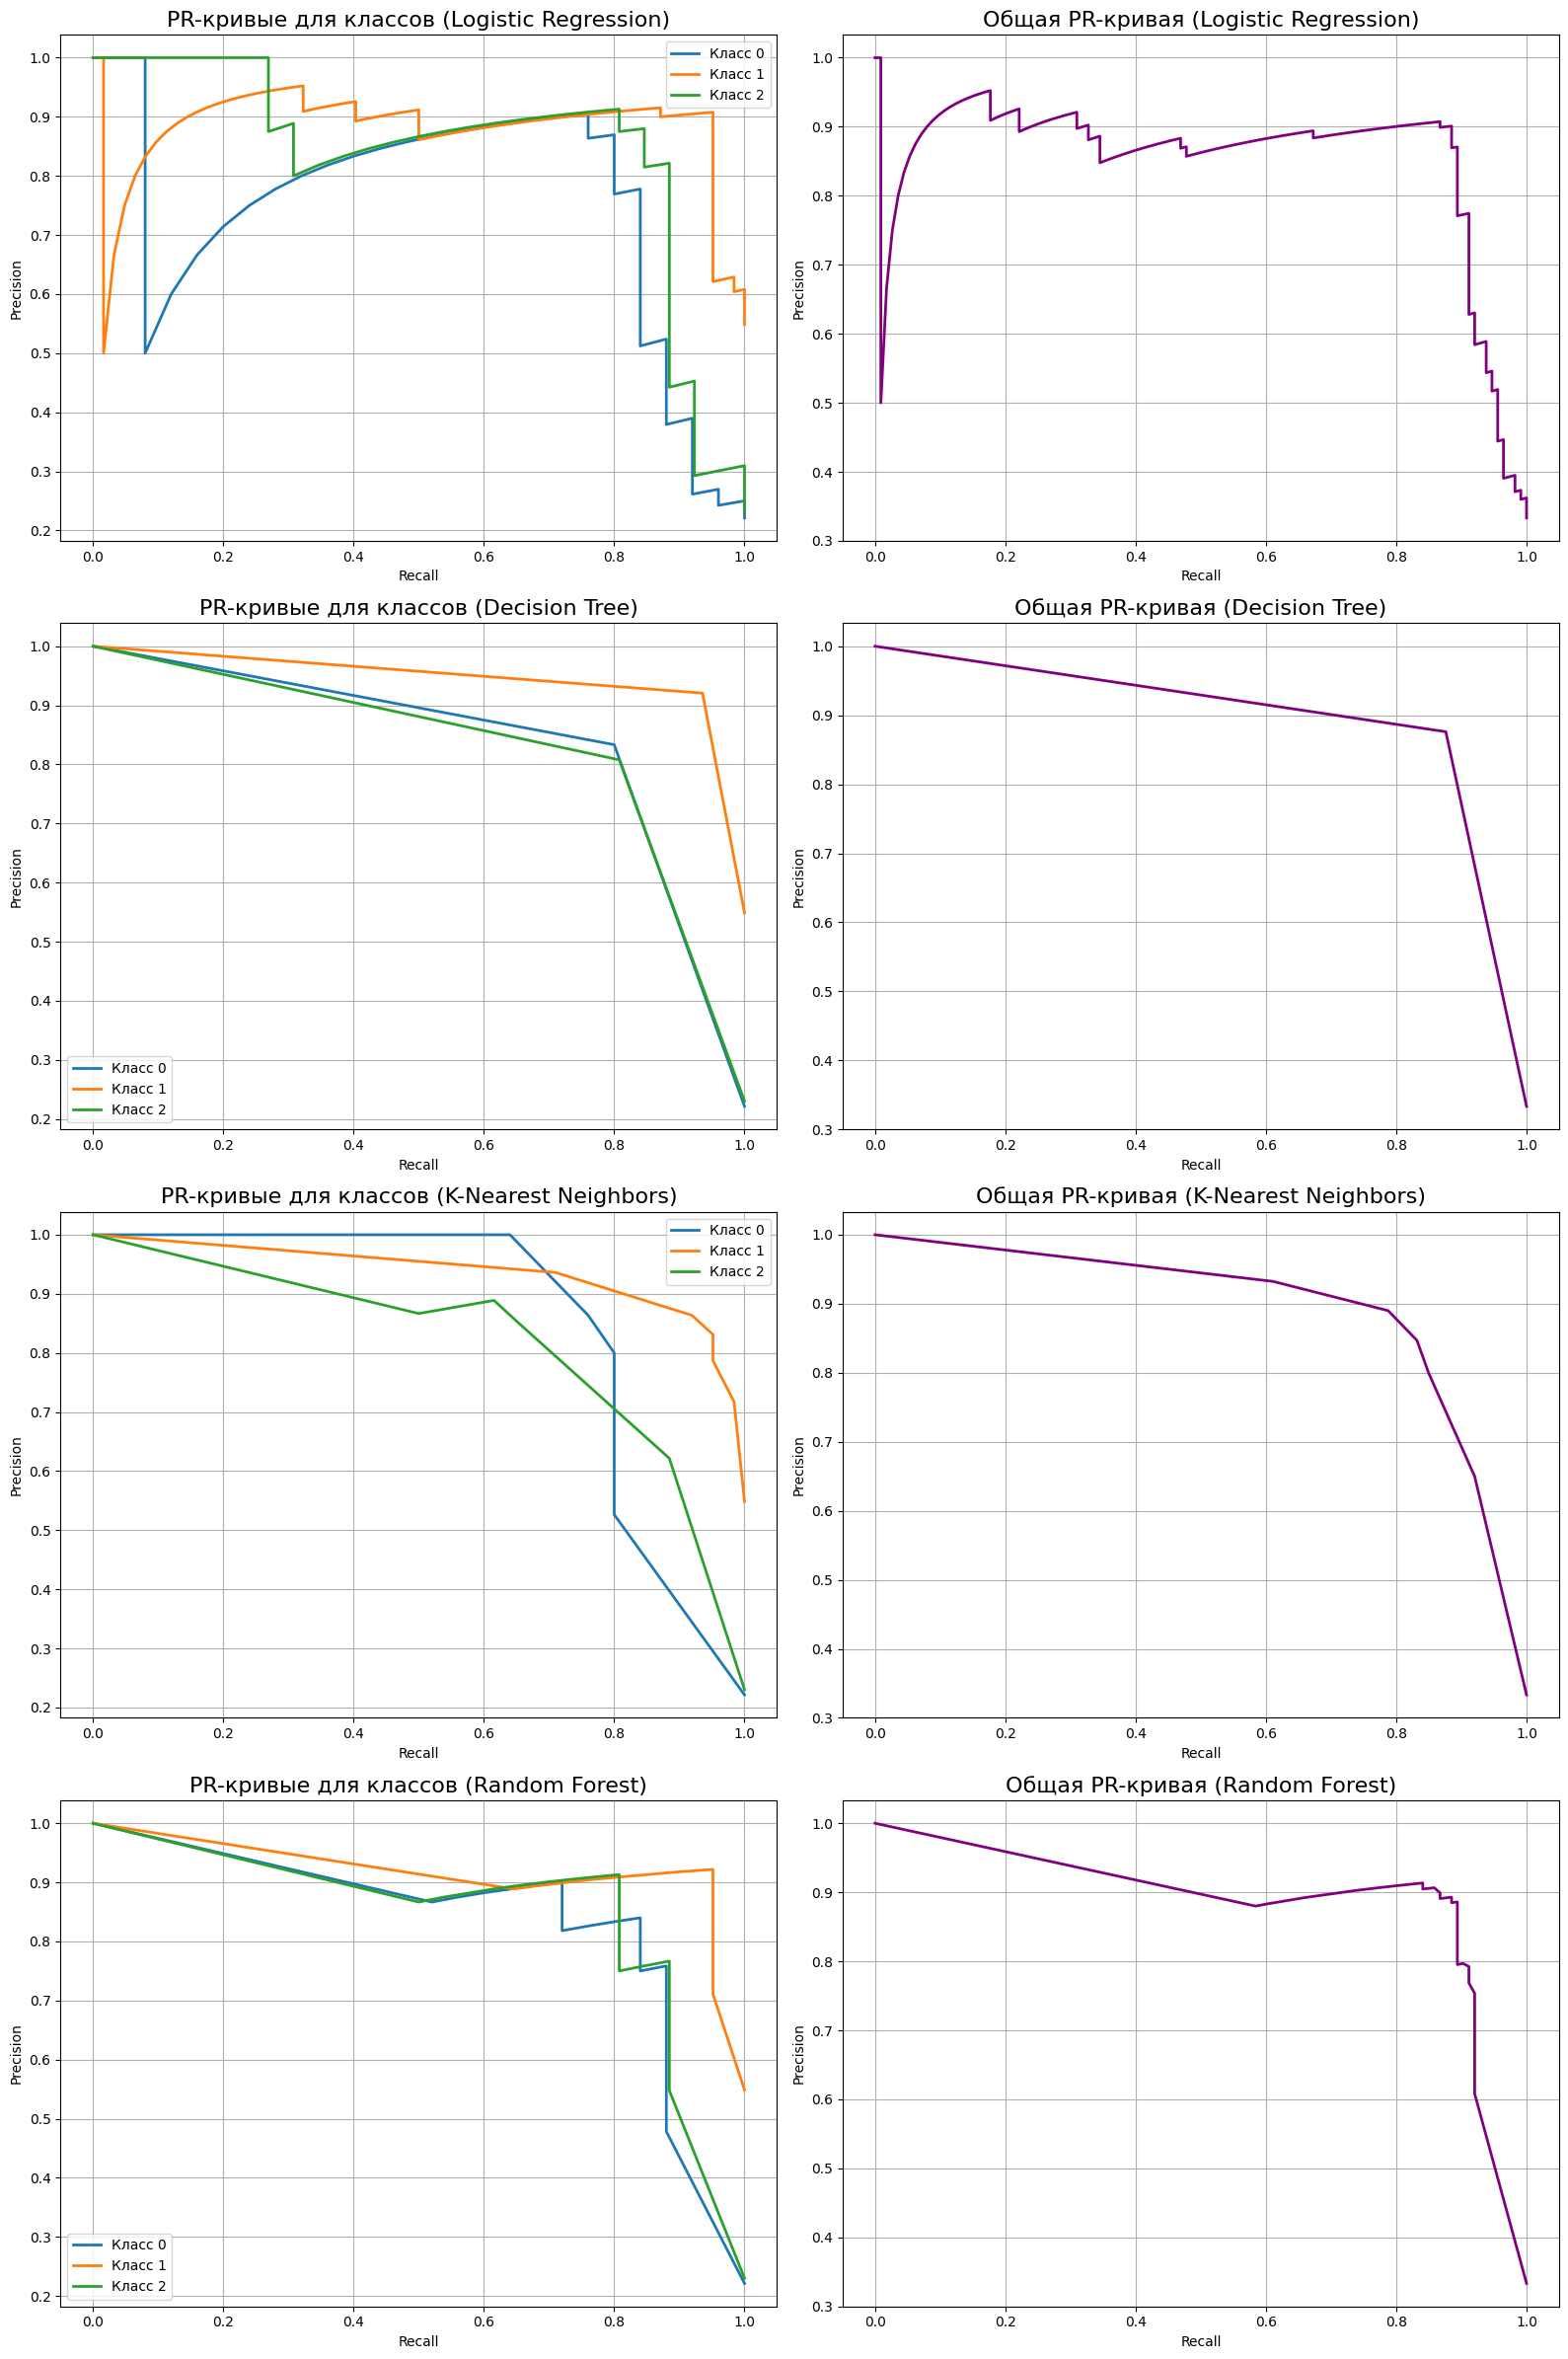

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
import numpy as np

y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

model_names = ["Logistic Regression", "Decision Tree", "K-Nearest Neighbors", "Random Forest"]
models = [log_model, tree_model, neigh_model, forest_model]

fig, axs = plt.subplots(len(models), 2, figsize=(16, 6 * len(models)))

for row in range(len(models)):
    model_name = model_names[row]
    model = models[row]

    y_pred_proba = model.predict_proba(X_test)

    # PR-кривые для классов 0, 1, 2
    for i in range(3):
        precision, recall, thresholds = precision_recall_curve(y_test_bin[:, i], y_pred_proba[:, i])
        axs[row, 0].plot(recall, precision, lw=2, label=f'Класс {i}')

    axs[row, 0].set_title(f'PR-кривые для классов ({model_name})', fontsize=16)
    axs[row, 0].set_xlabel('Recall')
    axs[row, 0].set_ylabel('Precision')
    axs[row, 0].legend(loc='best')
    axs[row, 0].grid(True)

    # общая PR-кривая
    precision_all, recall_all, thresholds_all = precision_recall_curve(y_test_bin.ravel(), y_pred_proba.ravel())
    axs[row, 1].plot(recall_all, precision_all, color='purple', lw=2)

    axs[row, 1].set_title(f'Общая PR-кривая ({model_name})', fontsize=16)
    axs[row, 1].set_xlabel('Recall')
    axs[row, 1].set_ylabel('Precision')
    axs[row, 1].grid(True)


plt.tight_layout()
plt.show()


Лучше всего Random Forest.

#### 5.1.4. F1-score

In [ ]:
import pandas as pd
from sklearn.metrics import f1_score

model_names = ["Logistic Regression", "Decision Tree", "K-Nearest Neighbors", "Random Forest"]

models = [log_model, tree_model, neigh_model, forest_model]

f1_results = {
    "Model": [],
    "F1 (Класс 0)": [],
    "F1 (Класс 1)": [],
    "F1 (Класс 2)": [],
    "Средний F1 (Weighted)": [],
}

for i in range(len(models)):
    model = models[i]
    model_name = model_names[i]
    y_pred = model.predict(X_test)
    f1_class = f1_score(y_test, y_pred, average=None)
    f1_weighted = f1_score(y_test, y_pred, average='weighted')

    f1_results["Model"].append(model_name)
    f1_results["F1 (Класс 0)"].append(f1_class[0])
    f1_results["F1 (Класс 1)"].append(f1_class[1])
    f1_results["F1 (Класс 2)"].append(f1_class[2])
    f1_results["Средний F1 (Weighted)"].append(f1_weighted)

f1_df = pd.DataFrame(f1_results)

print(display(f1_df))


,Model,F1 (Класс 0),F1 (Класс 1),F1 (Класс 2),Средний F1 (Weighted)
0,Logistic Regression,0.833333,0.921875,0.840000,0.883448
1,Decision Tree,0.816327,0.928000,0.807692,0.875612
2,K-Nearest Neighbors,0.775510,0.887218,0.727273,0.825702
3,Random Forest,0.840000,0.936508,0.840000,0.892951


None


Лучше всего в целом Random Forest.

### 5.2. Тренировачные данные

#### 5.2.1 Accuracy

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_log = accuracy_score(y_train, y_pred_log_train)
accuracy_tree = accuracy_score(y_train, y_pred_tree_train)
accuracy_neigh = accuracy_score(y_train, y_pred_neigh_train)
accuracy_forest = accuracy_score(y_train, y_pred_forest_train)

print("Accuracy")
print(f'  Для логистической регрессии: {accuracy_log:.4f}')
print(f'  Для дерева решений: {accuracy_tree:.4f}')
print(f'  Для KNN: {accuracy_neigh:.4f}')
print(f'  Для случайного леса: {accuracy_forest:.4f}')


Accuracy
  Для логистической регрессии: 0.9464
  Для дерева решений: 1.0000
  Для KNN: 0.8966
  Для случайного леса: 1.0000


Лучшие результаты на тестовых данных у Decision Tree и Random Forest

#### 5.2.2 ROC_AUC

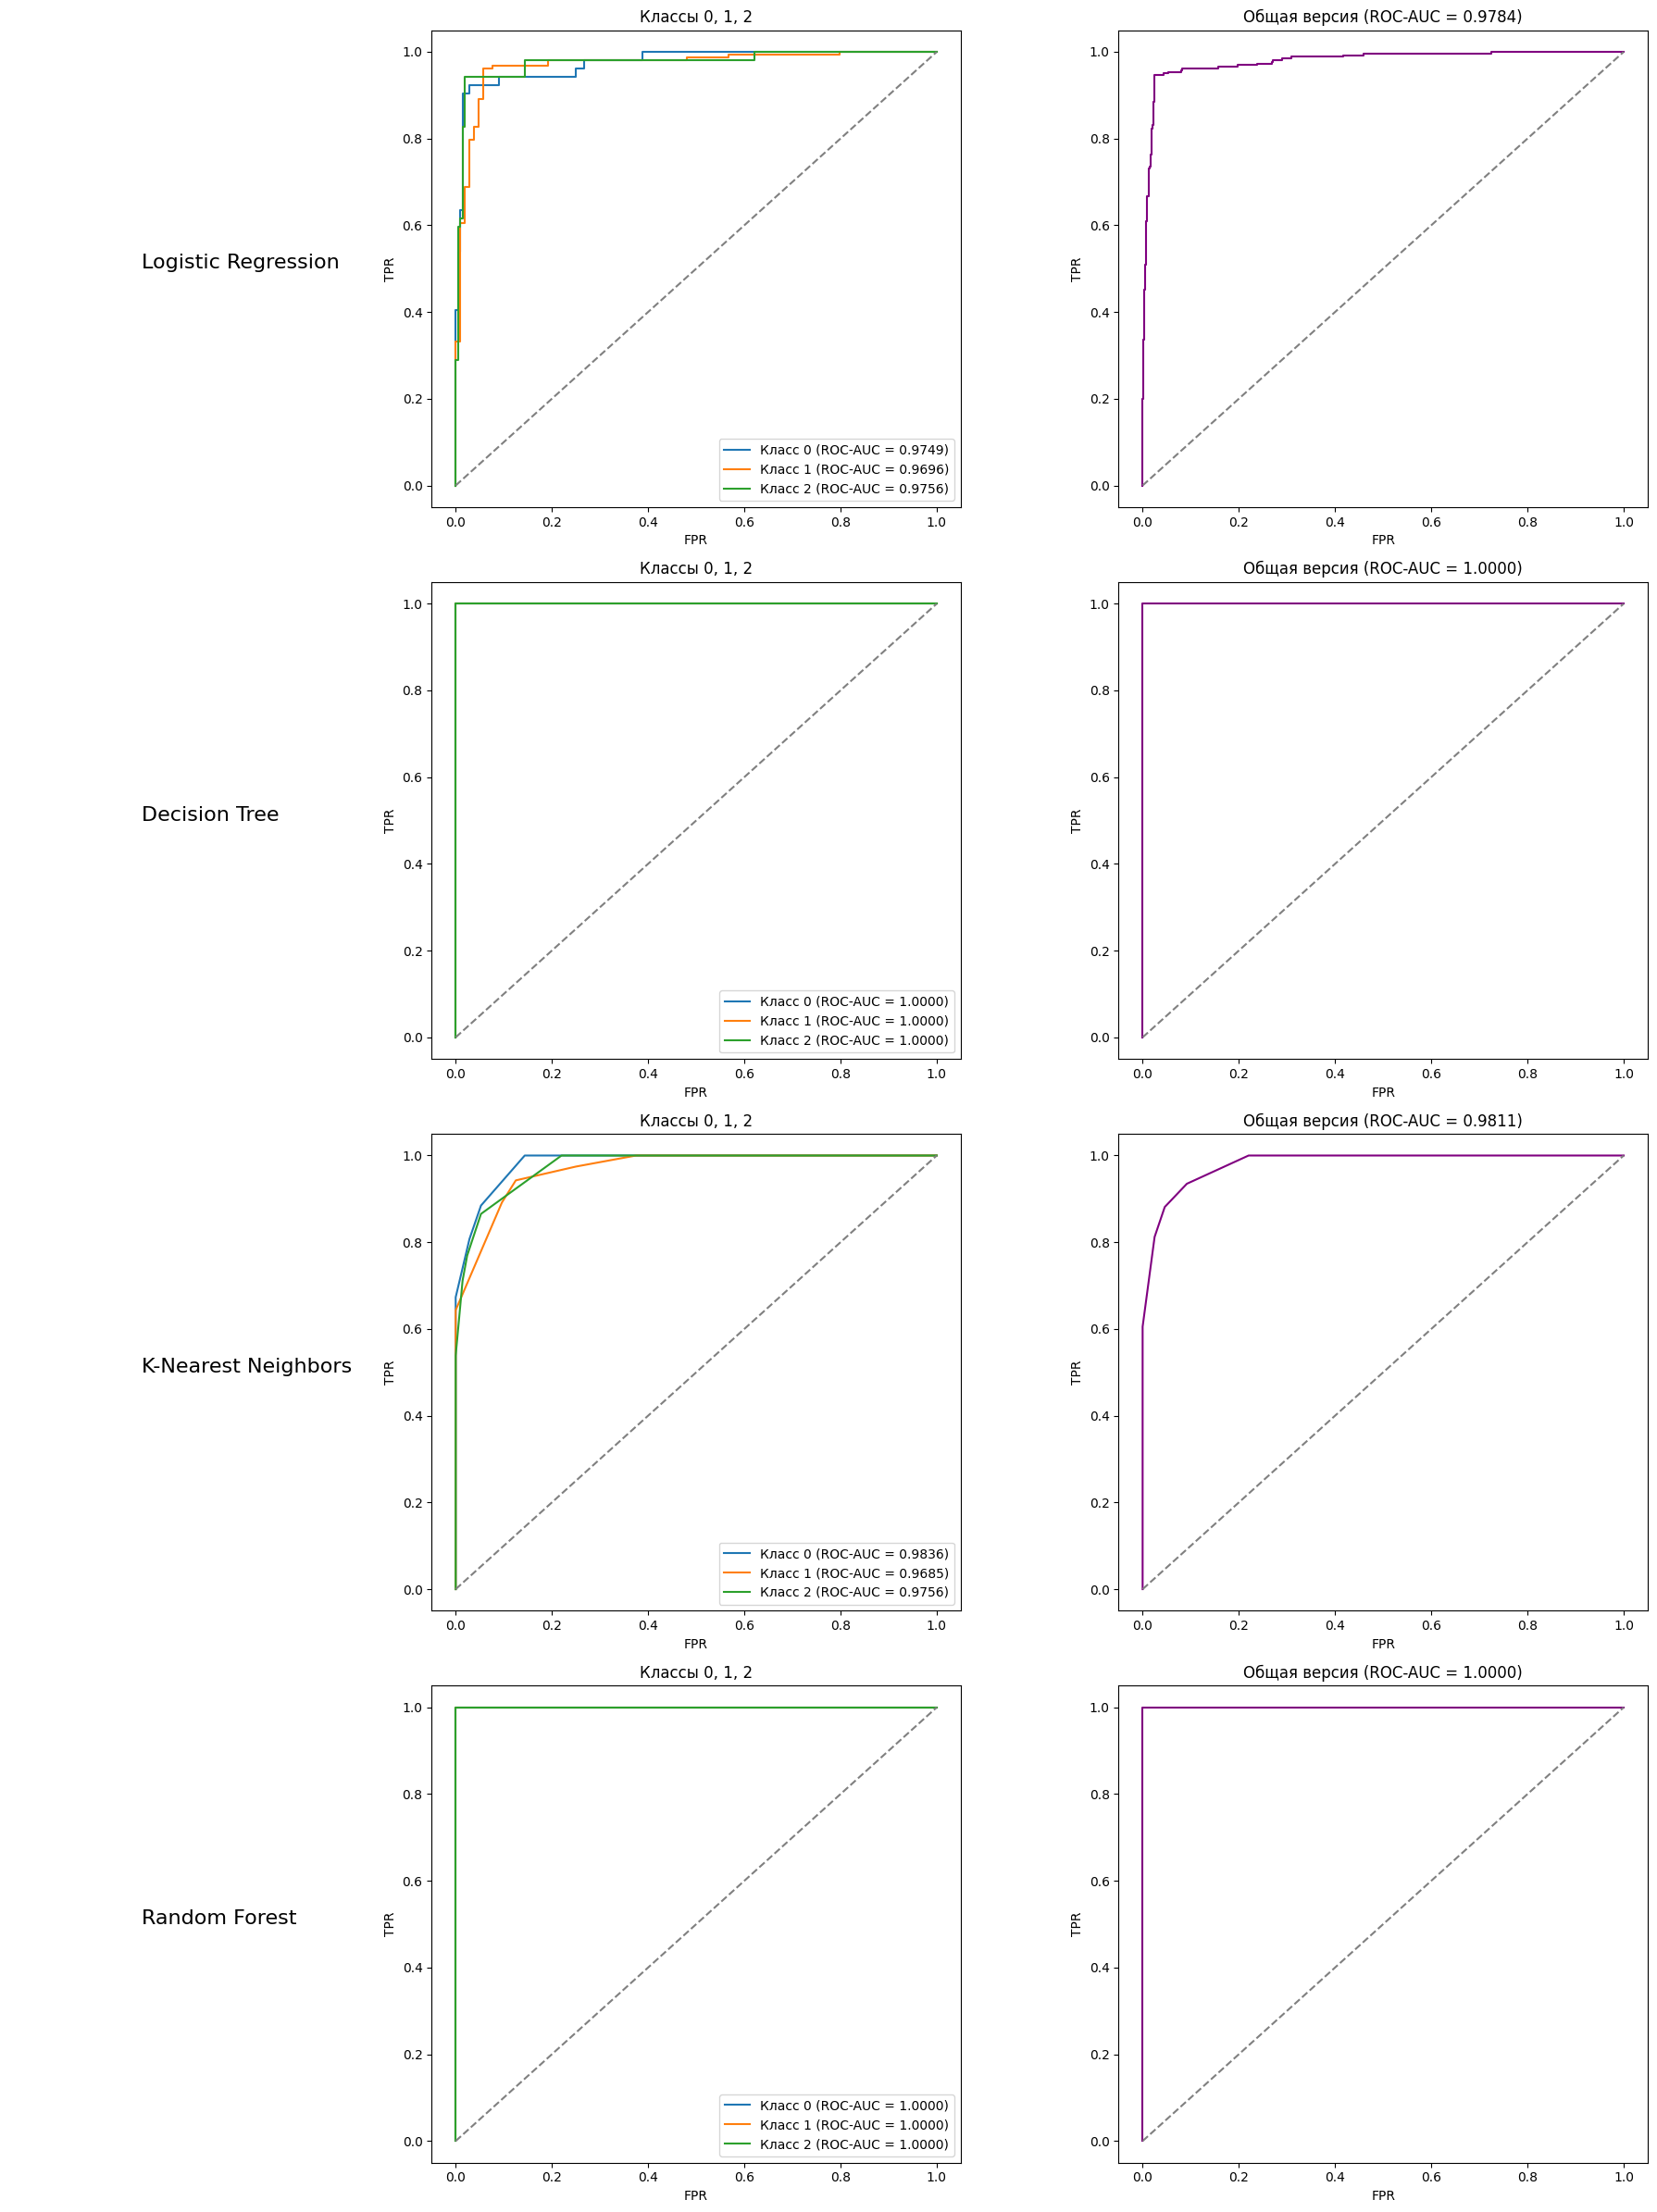

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# бинаризация целевой переменной (т.к. не 2, а 3 класса)
y_train_bin = label_binarize(y_train, classes=[0, 1, 2])

# вероятности для всех моделей
model_names = ["Logistic Regression", "Decision Tree", "K-Nearest Neighbors", "Random Forest"]
predictions = [
    log_model.predict_proba(X_train),
    tree_model.predict_proba(X_train),
    neigh_model.predict_proba(X_train),
    forest_model.predict_proba(X_train)
]

fig, axs = plt.subplots(4, 3, figsize=(18, 6 * len(model_names)),gridspec_kw={'width_ratios': [1, 2, 2]})

for row in range(len(model_names)):
    model_name = model_names[row]
    y_pred_proba = predictions[row]

    # название модели
    axs[row, 0].text(0.5, 0.5, model_name, fontsize=16)
    axs[row, 0].axis('off')

    # ROC для классов 0, 1, 2
    for i in range(3):
        fpr, tpr, thresholds = roc_curve(y_train_bin[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        axs[row, 1].plot(fpr, tpr, label=f'Класс {i} (ROC-AUC = {roc_auc:.4f})')
    axs[row, 1].plot([0, 1], [0, 1], color='grey', linestyle='--') # диагональ
    axs[row, 1].set_title("Классы 0, 1, 2")
    axs[row, 1].set_xlabel('FPR')
    axs[row, 1].set_ylabel('TPR')
    axs[row, 1].legend()

    # общий для всех классов
    fpr_all, tpr_all, thresholds_all = roc_curve(y_train_bin.ravel(), y_pred_proba.ravel())
    roc_auc_all = auc(fpr_all, tpr_all)
    axs[row, 2].plot(fpr_all, tpr_all, color='purple')
    axs[row, 2].plot([0, 1], [0, 1], color='grey', linestyle='--') # диагональ
    axs[row, 2].set_title(f"Общая версия (ROC-AUC = {roc_auc_all:.4f})")
    axs[row, 2].set_xlabel('FPR')
    axs[row, 2].set_ylabel('TPR')


plt.tight_layout()
plt.show()


Лучшие результаты - Decision Tree и Random Forest

#### 5.2.3 PR-кривая

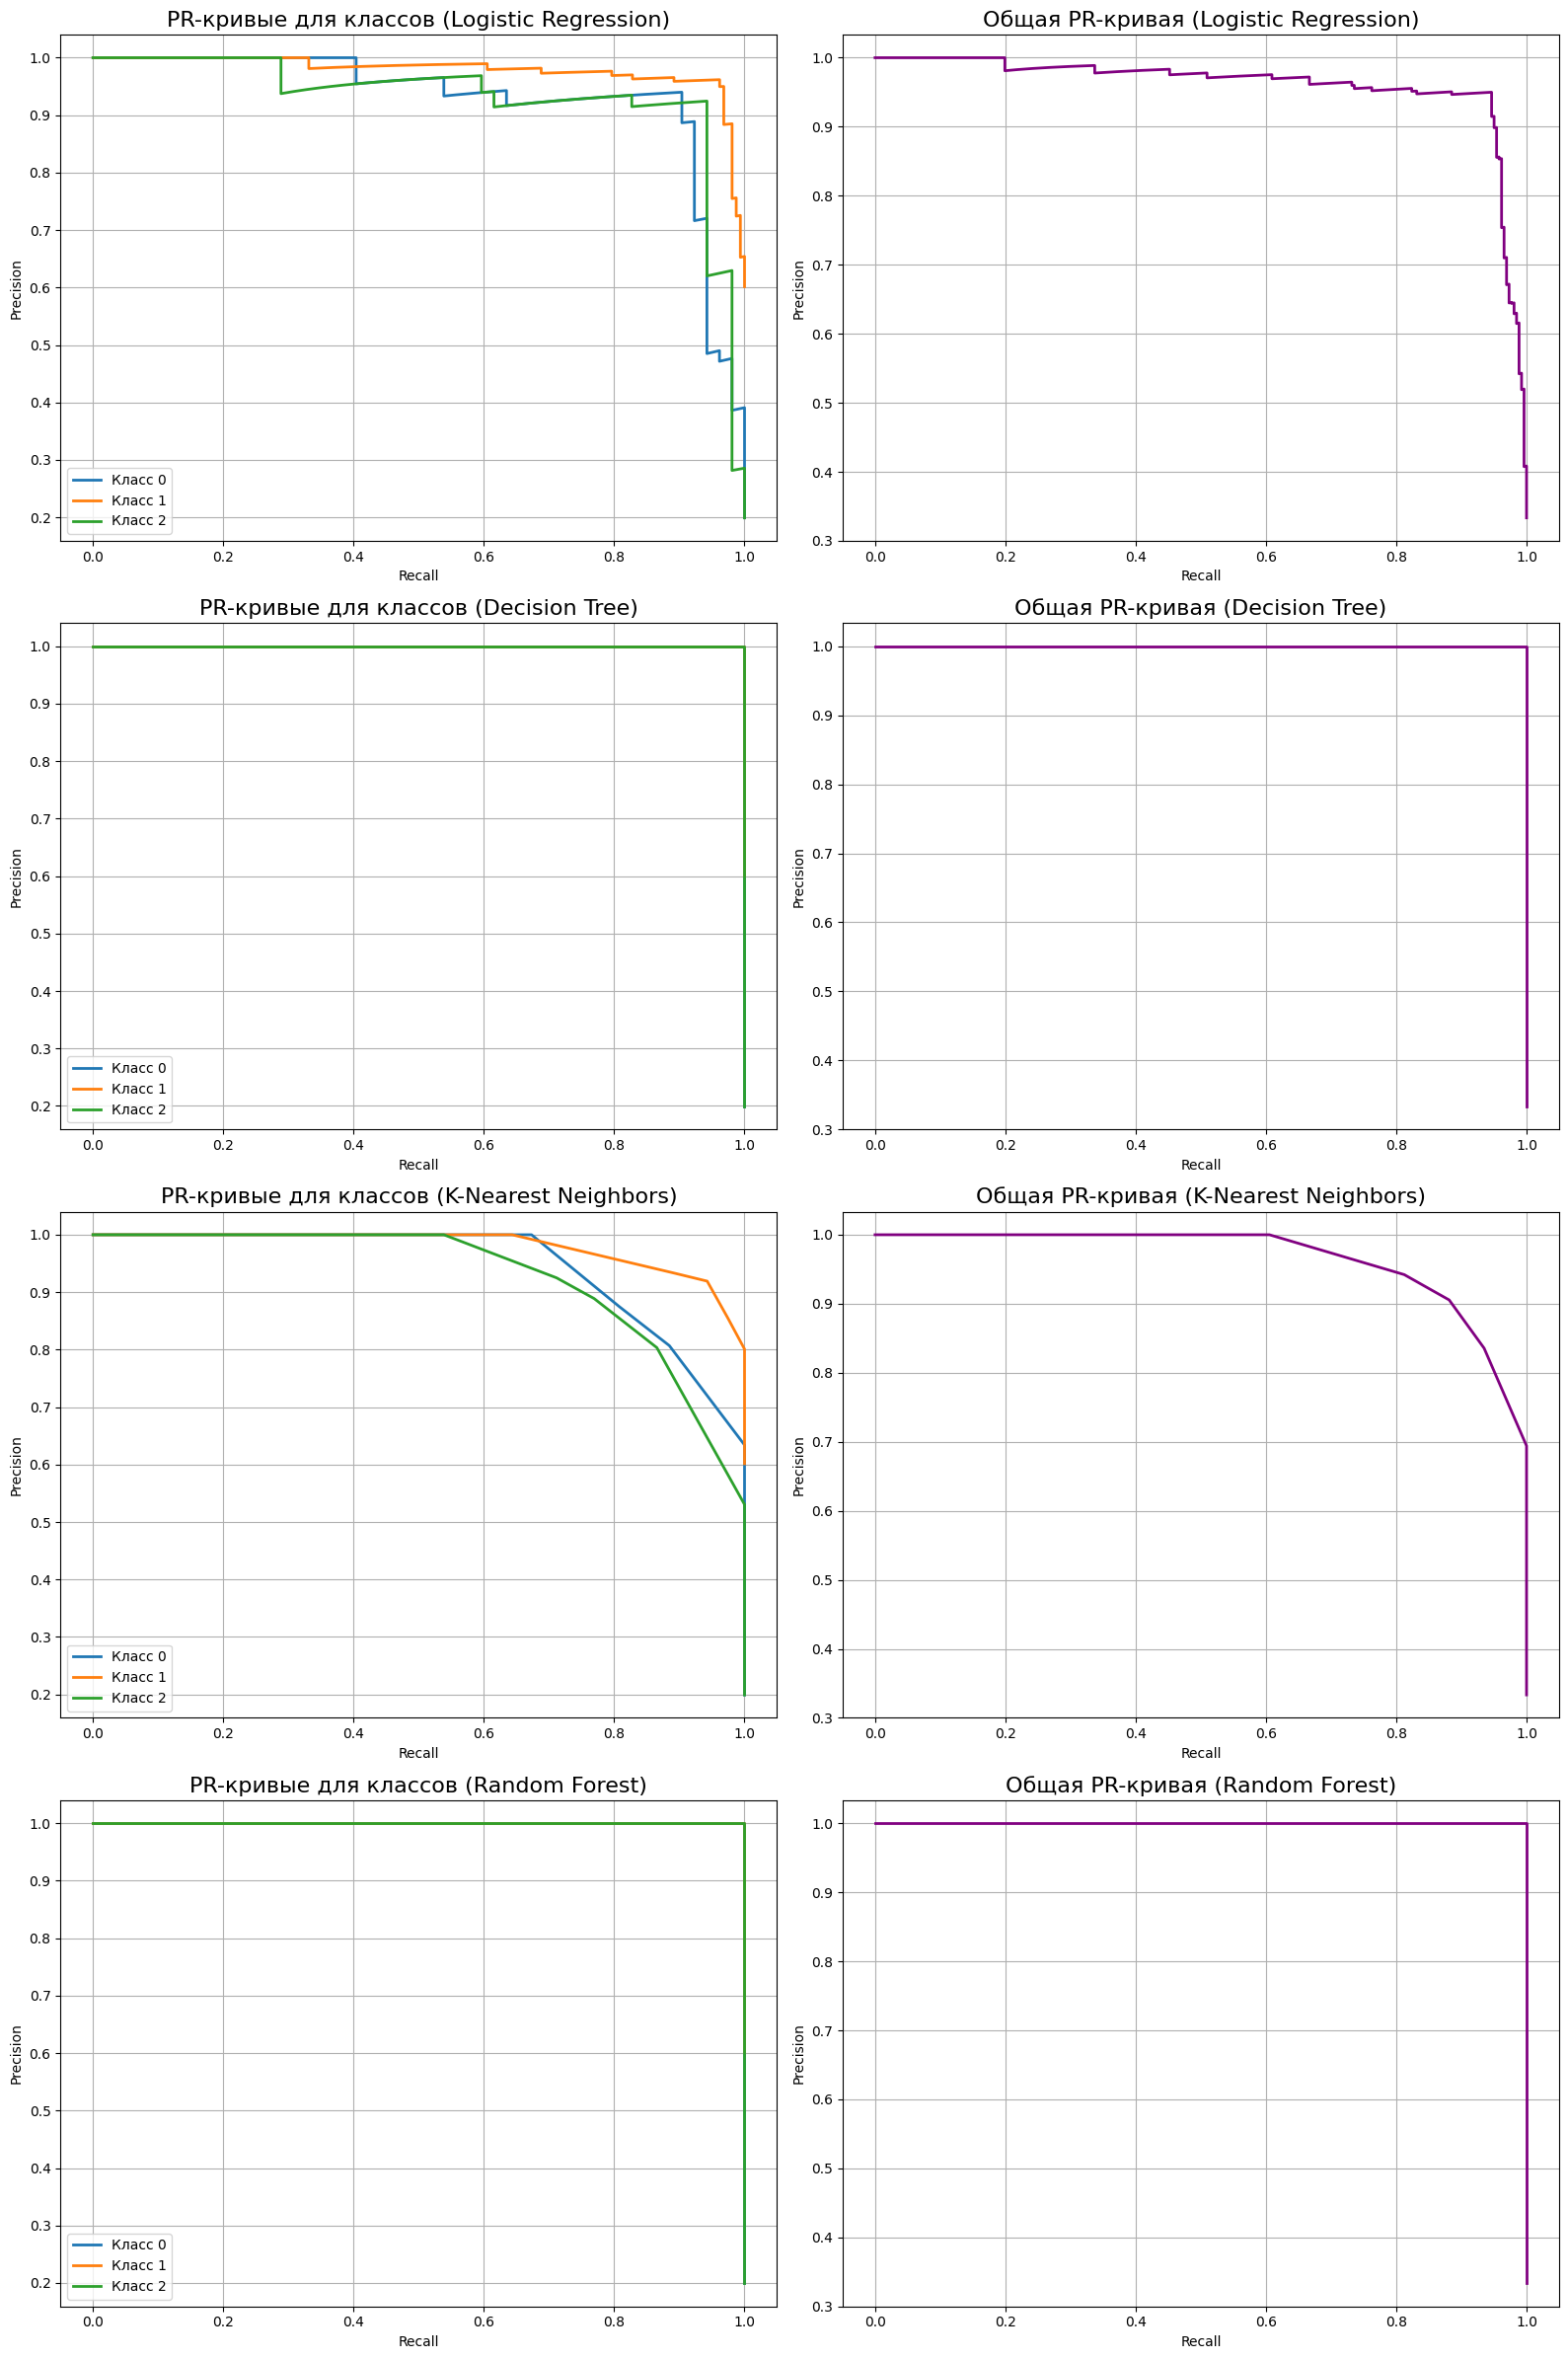

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
import numpy as np

y_train_bin = label_binarize(y_train_bin, classes=[0, 1, 2])

model_names = ["Logistic Regression", "Decision Tree", "K-Nearest Neighbors", "Random Forest"]
models = [log_model, tree_model, neigh_model, forest_model]

fig, axs = plt.subplots(len(models), 2, figsize=(16, 6 * len(models)))

for row in range(len(models)):
    model_name = model_names[row]
    model = models[row]

    y_pred_proba = model.predict_proba(X_train)

    # PR-кривые для классов 0, 1, 2
    for i in range(3):
        precision, recall, thresholds = precision_recall_curve(y_train_bin[:, i], y_pred_proba[:, i])
        axs[row, 0].plot(recall, precision, lw=2, label=f'Класс {i}')

    axs[row, 0].set_title(f'PR-кривые для классов ({model_name})', fontsize=16)
    axs[row, 0].set_xlabel('Recall')
    axs[row, 0].set_ylabel('Precision')
    axs[row, 0].legend(loc='best')
    axs[row, 0].grid(True)

    # общая PR-кривая
    precision_all, recall_all, _ = precision_recall_curve(y_train_bin.ravel(), y_pred_proba.ravel())
    axs[row, 1].plot(recall_all, precision_all, color='purple', lw=2)

    axs[row, 1].set_title(f'Общая PR-кривая ({model_name})', fontsize=16)
    axs[row, 1].set_xlabel('Recall')
    axs[row, 1].set_ylabel('Precision')
    axs[row, 1].grid(True)


plt.tight_layout()
plt.show()


Лучшие результаты на тестовых данных у Decision Tree и Random Forest

#### 5.2.4 F1-score

In [ ]:
import pandas as pd
from sklearn.metrics import f1_score

model_names = ["Logistic Regression", "Decision Tree", "K-Nearest Neighbors", "Random Forest"]

models = [log_model, tree_model, neigh_model, forest_model]

f1_results = {
    "Model": [],
    "F1 (Класс 0)": [],
    "F1 (Класс 1)": [],
    "F1 (Класс 2)": [],
    "Средний F1 (Weighted)": [],
}

# F1-score для каждой модели
for i in range(len(models)):
    model = models[i]
    model_name = model_names[i]
    y_pred = model.predict(X_train)
    f1_class = f1_score(y_train, y_pred, average=None)
    f1_weighted = f1_score(y_train, y_pred, average='weighted')

    f1_results["Model"].append(model_name)
    f1_results["F1 (Класс 0)"].append(f1_class[0])
    f1_results["F1 (Класс 1)"].append(f1_class[1])
    f1_results["F1 (Класс 2)"].append(f1_class[2])
    f1_results["Средний F1 (Weighted)"].append(f1_weighted)


f1_df = pd.DataFrame(f1_results)

print(display(f1_df))


,Model,F1 (Класс 0),F1 (Класс 1),F1 (Класс 2),Средний F1 (Weighted)
0,Logistic Regression,0.921569,0.958730,0.933333,0.946266
1,Decision Tree,1.000000,1.000000,1.000000,1.000000
2,K-Nearest Neighbors,0.859813,0.930818,0.824742,0.895537
3,Random Forest,1.000000,1.000000,1.000000,1.000000


None


Лучшие результаты на тестовых данных у Decision Tree и Random Forest

## 6. Сравнение метрик

### 6.1. Какая модель справилась лучше с поставленной задачей?

**На тренировочных данных**:

Во всех метриках лучше всех оказались одновременно DecisionTree и Random Forest

**На тестовых данных**:

Accuracy:Random Forest

ROC-AUC: Чуть лучше Logistic Regression, за ней - Random Forest

PR-кривая: Random Forest

F1-score: Random Forest

**Следовательно, лучше всех справилась модель Random Forest.**

### 6.2. Имеет ли место переобучение/недообучение?

В таблице ниже через слеш записаны значения метрики модели для тренировочных и тестовых данных.

В PR-кривой используется ранжировка. Кривые с рангом 1 являются самыми близкими к идеальной кривой. В тренировочных данных DecisionTree и RandomForest совпадают с идеальной кривой.

| Модель | Accuracy (train/test) | ROC-AUC (train/test) | PR-кривая (train/test) | F1-score (train/test) |
|-------------|-------------|-------------|-------------|-------------|
| LogisticRegression  | 0.9464/0.8850 | 0.9784 / 0.9234 | 3/4 | 0.9463/0.8835 |
| DesicionTree  | 1.0/0.8761 | 1.0 / 0.9071 | 1/3 | 1.0/0.8756|
| KNN  | 0.8966/0.8319 | 0.9811/0.9204 | 2/2 | 0.8955/0.8257|
| RandomForest  | 1.0/0.8938 | 1.0/ 0.9205 | 1/1 | 1/0.8929 |

**1. LogisticRegression**

    Accuracy: Разрыв есть, но он небольшой.

    ROC-AUC: Высокие значения, разрыв небольшой.

    PR-кривая: кривая достаточно далека от идеальной.

    F1-score: разрыв небольшой.

**Вывод**:
LogisticRegression находится в балансе. Легкий разрыв между тренировочными и тестовыми метриками незначительный. Даже на тренировочных данных модель не предсказывает значения идеально, следовательна модель не переобучена.

**2. DesicionTree**

    Accuracy: Большой разрыв. Модель идеальна на тренировочных данных.

    ROC-AUC: Большой разрыв. Модель идеальна на тренировочных данных.

    PR-кривая: Кривая совпадает с идеальной

    F1-score: Большой разрыв. Модель идеальна на тренировочных данных.

**Вывод**:
DesicionTree явно переобучена.

**3. KNN**

    Accuracy: Разрыв небольшой, но значения ниже, чем у остальных моделей.

    ROC-AUC: Разрыв небольшой.

    PR-кривая: Метрика имеет высокое, но не идеальное значение, в обоих случаях.

    F1-score: Разрыв небольшой.

**Вывод**:
KNN достаточно сбалансированная модель. Ее метрика ниже остальных моделей, так что есть вероятность, что она немного недообучена.

**4. RandomForest**

    Accuracy: Большой разрыв. Модель идеальна на тренировочных данных.

    ROC-AUC: Большой разрыв. Модель идеальна на тренировочных данных.

    PR-кривая: Кривая совпадает с идеальной

    F1-score: Большой разрыв. Модель идеальна на тренировочных данных.

**Вывод**:
RandomForest явно переобучена.

### 6.3. Как можно улучшить метрики моделей?

Для переобученных моделей:
1. Увеличение объема данных
2. Использование кросс-валидации
3. Регуляризация (например, для DecisionTree ограничить максимальную глубину дерева)


Для недообученных моделей:
1. Проведение более корректного масштабирования параметров
2. Усложнение модели (добавление учитываемых признаков, переход к более сложной модели)
3. Увеличение объема данных
4. Использование кросс-валидации